<a href="https://colab.research.google.com/github/2021-FIIT-Bc-projects/BP-Bielko-GAN-Docker/blob/main/x64_dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 64x64 DCGAN experiment

## Importy + mount drive


In [ ]:
# imports
from tensorflow.config import list_physical_devices
import tensorflow.keras.backend as k_backend

import sys
if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')
  output_path = "/content/drive/My Drive/gan_files"
  %rm -r /content/BP-Bielko-GAN-Docker
  %rm -r /content/src
  !git clone https://github.com/2021-FIIT-Bc-projects/BP-Bielko-GAN-Docker.git
  !cp -r /content/BP-Bielko-GAN-Docker/src /content/

from src.dcgan_models import *
from src.dcgan_functions import *

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Cloning into 'BP-Bielko-GAN-Docker'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 58 (delta 15), reused 51 (delta 11), pack-reused 0
Unpacking objects: 100% (58/58), done.


In [ ]:
list_physical_devices('GPU')

[]

## Stiahnutie Flickr-Faces-HQ datasetu
Možnosť A: Stiahnuť dataset nanovo - veľká pravdepodobnosť vyčerpania download kvóty

Možnosť B: Načítať pred-pripravený zip súbor s datasetom 

In [ ]:
# A
%cd /content/
!git clone https://github.com/NVlabs/ffhq-dataset.git
%cd ffhq-dataset
!python download_ffhq.py --thumbs

/content
fatal: destination path 'ffhq-dataset' already exists and is not an empty directory.
/content/ffhq-dataset
Parsing JSON metadata...
Traceback (most recent call last):
  File "download_ffhq.py", line 445, in <module>
    run_cmdline(sys.argv)
  File "download_ffhq.py", line 440, in run_cmdline
    run(**vars(args))
  File "download_ffhq.py", line 391, in run
    json_data = json.load(f, object_pairs_hook=OrderedDict)
  File "/usr/lib/python3.7/json/__init__.py", line 293, in load
    return loads(fp.read(),
KeyboardInterrupt


In [ ]:
# B
!mkdir /content/ffhq-dataset
!unzip "/content/drive/MyDrive/ffhq_dataset_thumbs/dataset_download.zip" -d "/content/ffhq-dataset"A

## Definície modelov, funkcií - TODO presuň do .py súborov, real sample dict + predeterined samples daj do sep. bunky

In [ ]:
# definicie modelu
default_width = 64
default_height = 64
default_dims = 100
pixel_depth = 3 #rgb

model_type = '0_to_1_leakyReLU_tanh_x64'

real_sample_dict = {}

p_dims = 100
p_n = 100
predetermined_inputs = np.random.randn(p_dims * p_n)  # n vektorov z gauss. distrib.
predetermined_inputs = predetermined_inputs.reshape(p_n, p_dims)

## Vytvorenie modelu

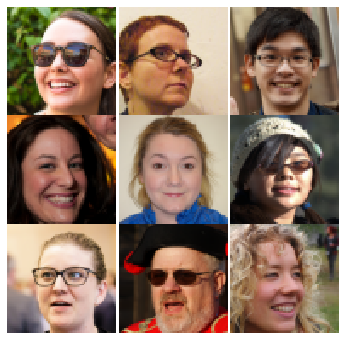

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
show_dataset() # realne vzorky z datasetu v aktualne zvolenom rozliseni
generator = make_generator()
discriminator = make_discriminator()
gan = make_gan_model(generator, discriminator)

## TODO tieto metadata ukladaj, zapisuj do metadata list index z batch namiesto času v hod.

In [ ]:
open(f'{output_path}/{model_type}/outputs/evaluation/epoch_metadata.txt', 'w').close()

In [ ]:
metadata_list = []

## Trénovací proces

In [ ]:
from_epoch = 10
to_epoch = 12

a = datetime.datetime.now()

train_gan(gan, generator, discriminator, dataset_size, metadata_list,
          n_dim=100, start_epoch=from_epoch, n_epochs=to_epoch, 
          n_batch=dataset_size//700, n_eval=10, eval_samples=100, n_plot=50, plot_size=9)

b = datetime.datetime.now()
print("Time taken: ", b - a)

generator.save_weights(f"{output_path}/{model_type}/saves/generator_{to_epoch}.hdf5", overwrite=True)
discriminator.save_weights(f"{output_path}/{model_type}/saves/discriminator_{to_epoch}.hdf5", overwrite=True)

[Epoch 10] Batch 0/1400


TypeError: ignored

Načítať uložené weights podľa epochy

In [ ]:
load_epoch = 10

generator.load_weights(f"{output_path}/{model_type}/saves/generator_{load_epoch}.hdf5")
discriminator.load_weights(f"{output_path}/{model_type}/saves/discriminator_{load_epoch}.hdf5")

## Vyhodnotenie trénovania - TODO

In [ ]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

def Extract(lst, index):
    return [item[index] for item in lst]

fig = plt.figure()
fig, axs = plt.subplots(2)
p1 = axs[0].plot(Extract(metadata_list,0), Extract(metadata_list,1), 'r-o', label='Disc. loss real')
p2 = axs[0].plot(Extract(metadata_list,0), Extract(metadata_list,2), 'g-o', label='Disc. loss fake')
p3 = axs[0].plot(Extract(metadata_list,0), Extract(metadata_list,3), 'b-o', label='Gen. loss')

p4 = axs[1].plot(Extract(metadata_list,0), Extract(metadata_list,4), 'k-o', label='Acc. real')
p5 = axs[1].plot(Extract(metadata_list,0), Extract(metadata_list,5), 'm-o', label='Acc. fake')

axs[0].legend(loc="upper left")
axs[1].legend(loc="upper left")

fig.set_size_inches(18.5, 10.5)

plt.show()
plt.close(fig)

with open("SAVEDLIST.txt") as listfile:
    listfile.write()
# print(metadata_list)

## Koláž výstupov generátora

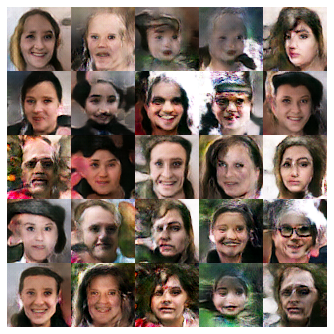

In [ ]:
fig = generate_and_plot(generator, 100, predetermined_inputs, 25)
plt.show(fig)

## Náhľad do vnútorných vrstiev generátora - filter po filtri

In [ ]:
get_all_layer_outputs = k_backend.function([generator.layers[0].input],
                                  [l.output for l in generator.layers[2:-1]])

latent_p = predetermined_inputs[:10]
layer_output = get_all_layer_outputs(latent_p) # return the same thing
for output in layer_output:
  print(output.shape)
  rgb = np.hstack((float_to_rgb(output[0, :, :, i]) for i in range(10)))
  print(rgb.shape)
  plt.imshow(rgb)
  plt.show()
plt.close()

## Plynulý prechod medzi dvoma vzorkami - TODO animovať

In [ ]:
pointA = predetermined_inputs[24]
pointB = predetermined_inputs[35]
transition = latent_transition(pointA, pointB, n_dim=100, n_steps=100)
input_points = random_latent_points(100, 10)
print(transition.shape)

fig = generate_and_plot(generator, 100, transition, 100)
# fig = generate_and_animate(generator, 100, transition, 25)
plt.show(fig)

# for transition_sample in transition:
#     transition_sample = transition_sample.reshape(1,100)
#     X,_ = generate_fake_samples(generator, transition_sample, 100, 1)
#     plt.axis('off')
#     plt.imshow(float_to_rgb(X[0]))
#     plt.show()
#     plt.close()